# PART A

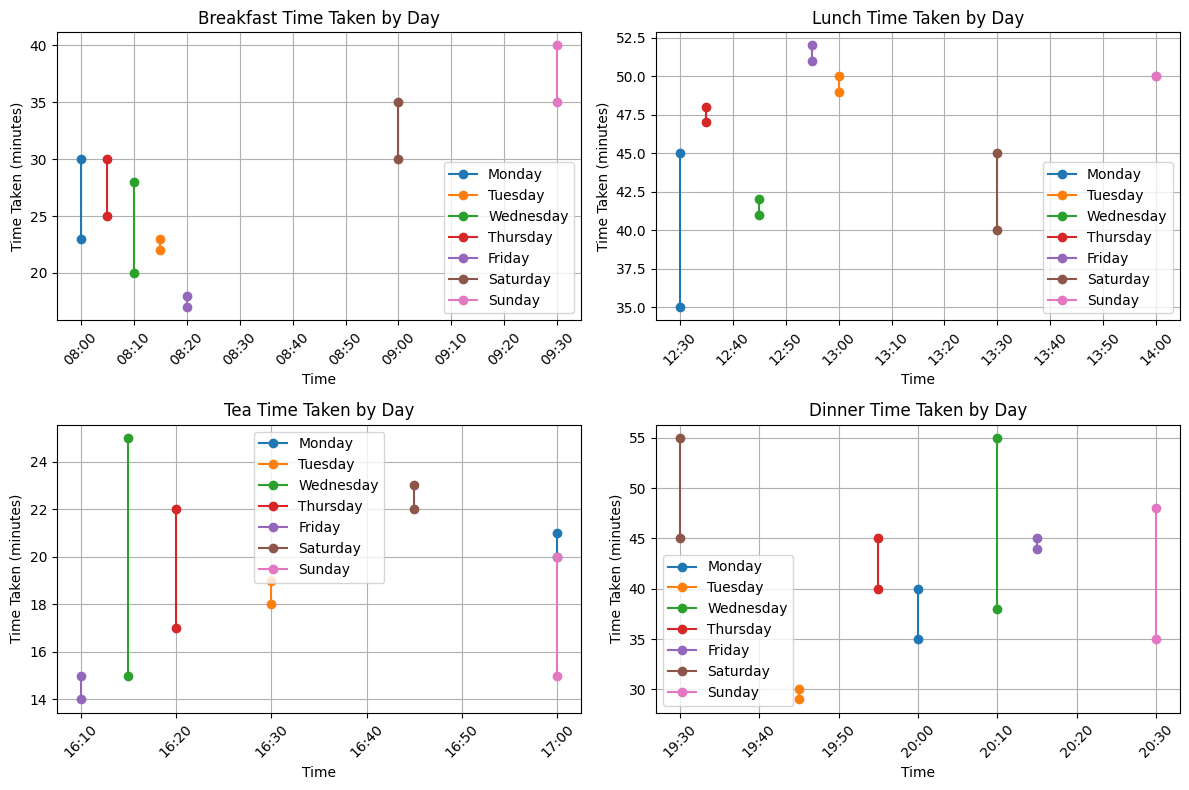

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
#for handling the time and date
import matplotlib.dates as mdates
df = pd.read_csv('./data_p1.csv')

# Convertint the "Time" column to a datetime object
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

# order of days for plotting
days_order = [
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
]

#separate plots for each meal type
meal_types = df['Meal'].unique()

plt.figure(figsize=(12, 8))

for meal_type in meal_types:
    meal_data = df[df['Meal'] == meal_type]

    # Create a subplot for each meal type
    plt.subplot(2, 2, meal_types.tolist().index(meal_type) + 1)

    # Iterate through days and plot the time taken
    for day in days_order:
        day_data = meal_data[meal_data['Day'] == day]
        plt.plot(day_data['Time'], day_data['TimeTakenToFinish'], marker='o', label=day)

    plt.title(f'{meal_type} Time Taken by Day')
    plt.xlabel('Time')
    plt.ylabel('Time Taken (minutes)')
    plt.xticks(rotation=45)

    # Formating x-axis  (HH:MM)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



# Mean Time to complete each type of Meal

Mean time for Breakfast: 26.86 minutes
Mean time for Lunch: 46.07 minutes
Mean time for Tea: 19.00 minutes
Mean time for Dinner: 41.71 minutes


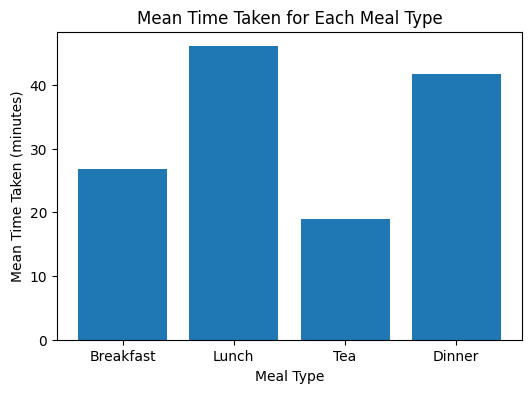

In [2]:
# Mean time for each meal type
mean_times = {}
for meal_type in meal_types:
    meal_data = df[df['Meal'] == meal_type]
    mean_time = meal_data['TimeTakenToFinish'].mean()
    mean_times[meal_type] = mean_time

for meal_type, mean_time in mean_times.items():
    print(f"Mean time for {meal_type}: {mean_time:.2f} minutes")

# Plot to visualize the mean times for each type of meal
plt.figure(figsize=(6, 4))
plt.bar(mean_times.keys(), mean_times.values())
plt.title("Mean Time Taken for Each Meal Type")
plt.xlabel("Meal Type")
plt.ylabel("Mean Time Taken (minutes)")
plt.show()

# PART B and C

In [4]:

import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# onehot encoder for changing the categorial data to numeric
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

# Pre Defining function to caculate the various Evaluation Matrics

In [5]:
def evaluation_matric(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    n = len(actual)
    # mean square error
    mse = sum((actual - predicted)**2) / n
    mean_actual = sum(actual) / n
    ssr = sum((actual - mean_actual)**2)
    r2 = 1 - (mse / ssr)
    rmse = mse**0.5
    return mse, r2, rmse

# Data Preparation

In [7]:
df = pd.read_csv('./problem_sec.csv')

# converting time to numeric format to use in the model
df['Time'] = pd.to_timedelta(df['Time']).dt.total_seconds()


X = df[['Day', 'Time', 'Holiday', 'NumberOfPeople', 'Meal']]
y = df['TimeTakenToFinish']

# Spliting the data in 80%traning and 20% test

In [8]:
# Spliting the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Generalised Linear Model
For modelling non-negative continuous data with a skewed distribution, *the Gamma distribution is an appropriate probability distribution. When the relationship is multiplicative, the Log link function is a viable option for modelling the relationship between the independent variables and the response variable.*
# Features
*The day, time, holiday status, and meal type are the features I picked for the model. All of these characteristics are pertinent to the issue of estimating how long it will take to finish a meal that is a mess. The effects of various mealtimes, for instance, can be captured using the day and time elements.*


In [9]:
#  GLM  model
formula = 'TimeTakenToFinish ~ Day + Time + Holiday + NumberOfPeople + Meal'

# Fiting the model on the training data
model = sm.GLM.from_formula(formula=formula, data=pd.concat([X_train, y_train], axis=1), family=sm.families.Gamma(link=sm.families.links.Log()))
result = model.fit()

# Learned Parameters

In [10]:
# model parameters
print('Model Parameters:')
print(result.params)

Model Parameters:
Intercept           0.847936
Day[T.Monday]       0.047735
Day[T.Saturday]     0.051081
Day[T.Sunday]      -0.167904
Day[T.Thursday]     0.104402
Day[T.Tuesday]     -0.019744
Day[T.Wednesday]    0.121987
Holiday[T.Yes]     -0.116823
Meal[T.Dinner]     -2.401387
Meal[T.Lunch]      -0.697703
Meal[T.Tea]        -2.123973
Time                0.000065
NumberOfPeople      0.007446
dtype: float64


# Important Parameters

In [13]:
# important parameters (with higher coefficients)
important_params = [param for param, value in result.params.items() if abs(value) > 0.5]
print('Important parameters:', important_params)

# prediction on traning daata
y_pred = result.predict(X_test)


Important parameters: ['Intercept', 'Meal[T.Dinner]', 'Meal[T.Lunch]', 'Meal[T.Tea]']


# Calculating the various Evaluation martrics for GLM

In [14]:
# calculating evaluation matric using defined function
mse, r2, rmse = evaluation_matric(y_test, y_pred)

print('Mean squared error:', mse)
print('R-squared value:', r2)
print('RMSE value:', rmse)

Mean squared error: 20.495852639184175
R-squared value: 0.98952288682981
RMSE value: 4.527234546517794


# Vizualizing the actual vs predicted values on our model

Text(0.5, 1.0, 'Actual vs. Predicted')

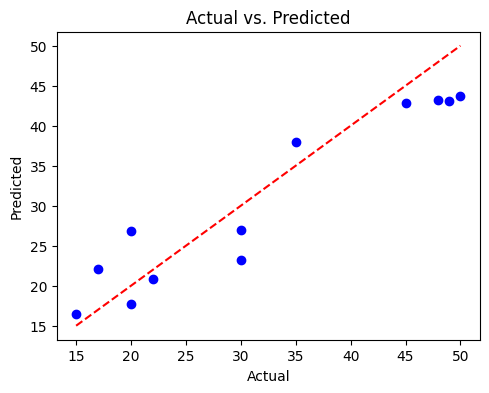

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

# Now Linear Model to Compare
using on hot encoding to use categorial data as numeric

In [17]:
# One-hot encode 'Day' and 'Meal' to use in  Linear Regression
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_train_encoded = encoder.fit_transform(X_train[['Day', 'Meal']])
X_test_encoded = encoder.transform(X_test[['Day', 'Meal']])

# Addinng all features
X_train_encoded = np.hstack((X_train_encoded, X_train[['Time', 'NumberOfPeople']].values))
X_test_encoded = np.hstack((X_test_encoded, X_test[['Time', 'NumberOfPeople']].values))

# fit linear model and prediction

In [18]:
# Fit  linear regression model
linear_M = LinearRegression()
linear_M.fit(X_train_encoded, y_train)

# Make predictions on the test data using linear regression
y_pred_linear_M = linear_M.predict(X_test_encoded)

# various Evaluation matrics for LInear Model

In [19]:
#  Mean Squared Error (MSE) for linear regression
mse_linear_M = np.mean((y_pred_linear_M - y_test)**2)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# R-squared ->linear Regression
r2_linear_M = r2_score(y_test, y_pred_linear_M)
#RMSE->linear regression
rmse_linear_M = np.sqrt(mse_linear_M)

print('MSE on test data for linear regression:', mse_linear_M)
print('R-squared value (Linear Regression):', r2_linear_M)
print('RMSE value (Linear Regression):', rmse_linear_M)

MSE on test data for linear regression: 22.140262900708876
R-squared value (Linear Regression): 0.864187524698527
RMSE value (Linear Regression): 4.705344078886142


#vizualization of linear VS GLM evaluation metrics

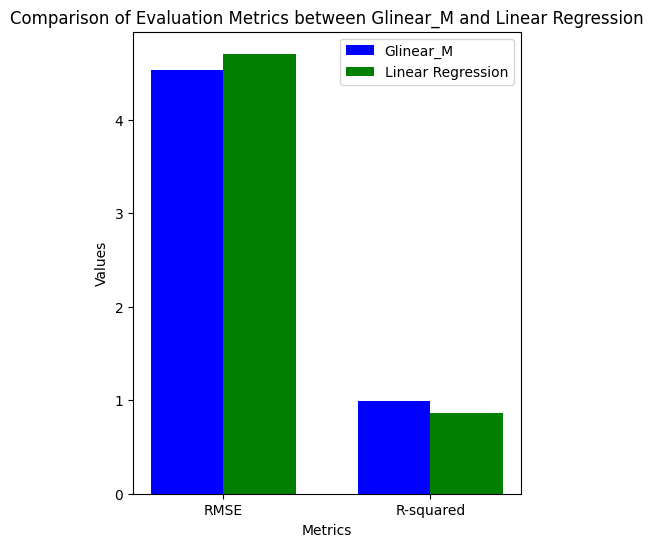

In [20]:
## vizualization of linear VS GLM evaluation metrics
metrics = ['RMSE', 'R-squared']
glinear_M_metrics = [rmse, r2]
linear_M_metrics = [rmse_linear_M, r2_linear_M]
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(5, 6))
bar1 = ax.bar(x - width/2, glinear_M_metrics, width, label='Glinear_M', color='blue')
bar2 = ax.bar(x + width/2, linear_M_metrics, width, label='Linear Regression', color='green')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Evaluation Metrics between Glinear_M and Linear Regression')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

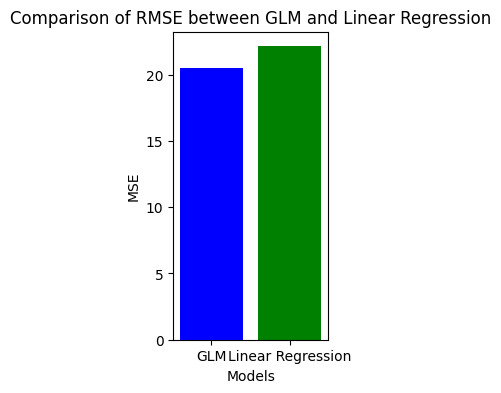

In [21]:
# comparision of MSE values of LInear REgression VS GLM
models = ['GLM', 'Linear Regression']
rmse_values = [mse, mse_linear_M]

plt.figure(figsize=(2, 4))
plt.bar(models, rmse_values, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('MSE')
plt.title('Comparison of RMSE between GLM and Linear Regression')
plt.show()

# we can see that the R-squared value of GLM is higher than the Linear Regression model ,also MSE and RMSE value of Linear Regression model is Higher than than MSE and RMSE vale es of GML model which indicate that GLM is better